## Comunicación con instrumentos - Laboratorio 3

Esta notebook tiene las instrucciones básicas de comunicación con un osciloscopio y un generador de funciones. Encontrarán:

1. Manejo del osciloscopio
   
    a. Comienzo de la comunicación y adquisición de la pantalla. 
    
    b. Seteo de escalas de la pantalla


2. Manejo del generador

    a. Seteo de la frecuencia y de la amplitud
   
    b. Realizar un barrido en frecuencia y adquirir el resultado con el osciloscopio.

Enlaces útiles:

a. [github de Hernán Grecco - Diego Shalom (DF-UBA)](https://github.com/hgrecco/labosdf/tree/master)

b. [github de Marcelo Luda (DF-UBA)](https://marceluda.github.io/python-para-fisicos/tuto/labo2/05_instrumentacion/) 


In [ ]:
import pyvisa as visa
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

## Manejo del osciloscopio

Osciloscopio Tektronix TBS1052b. 

Manuales:

1. Manual de operación: [link](https://download.tek.com/manual/TBS1000B-User-Manual-077088602-RevA.pdf)
2. Manual de programación: [link](https://download.tek.com/manual/TBS1000-B-EDU-TDS2000-B-C-TDS1000-B-C-EDU-TDS200-TPS2000-Programmer_EN-US-RevA.pdf)


In [20]:
# Abro el resource manager
rm = visa.ResourceManager()
# Me fijo que instrumentos tengo conectados
rm.list_resources()

('USB0::0xF4EC::0xEE38::SDG1XCA4161035::INSTR',
 'ASRL1::INSTR',
 'ASRL10::INSTR')

In [ ]:
# Nombro cada instrumento
resource_name_osc='USB::0x0699::0x0368::C033542::INSTR'  #Aqui deben colocar el nombre que les figure
#Guardo el instrumento en una variable
osci = rm.open_resource(resource_name_osc)
#Le pido a los instrumentos que se identifiquen
print(osci.query('*IDN?'))

TEKTRONIX,TBS 1052B,C033542,CF:91.1CT FV:v4.06



**Adquisición básica**

Text(0,0.5,'Voltaje [V]')

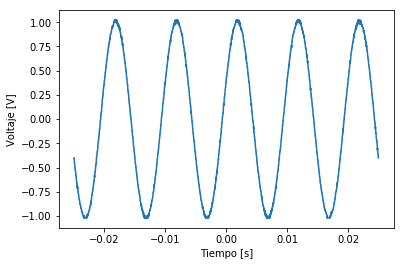

In [ ]:
# Le pido algunos parametros de la pantalla, para poder escalear adecuadamente
xze, xin, yze, ymu, yoff = osci.query_ascii_values('WFMPRE:XZE?;XIN?;YZE?;YMU?;YOFF?;', separator=';')

# Con el método 'write' enviamos instrucciones QUE NO TIENEN RESPUESTA
# Modo de transmisión: Binario
osci.write('DAT:ENC RPB')
osci.write('DAT:WID 1')

# Adquiere los datos del canal 1 y los devuelve en un array de numpy
data = osci.query_binary_values('CURV?', datatype='B', container=np.array)

voltaje =(data-yoff)*ymu+yze;
tiempo = xze + np.arange(len(data)) * xin

plt.plot(tiempo, voltaje )
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')

**Seteo de la escala vertical y horizontal de la pantalla**

In [ ]:
# Le preguntamos al osciloscopio la escala vertical del canal 1
print("La escala vertical es: ", osci.query("CH1:SCAle?"))

# Cambiamos la escala vertical:
osci.write("CH1:SCAle 0.25")
print("La escala vertical es: ", osci.query("CH1:SCAle?"))


# Preguntamos la escala horizontal
print("La escala horizontal es: ", osci.query("HORizontal:MAIn:SCAle?"))
print("La escala horizontal es: ", osci.query("HORizontal:SCAle?"))

# Cambiamos la escala horizontal
osci.write("HORizontal:MAIn:SCAle 0.001")
print("La escala horizontal es: ", osci.query("HORizontal:SCAle?"))

La escala vertical es:  5.0E-1

La escala vertical es:  2.5E-1

La escala horizontal es:  5.0E-3

La escala horizontal es:  5.0E-3

La escala horizontal es:  1.0E-3



**Utilizar el autorange para automaticamente setear las escalas**

Con el siguiente comando se setea el estado de autorange en activado.

Esto quiere decir que el osciloscopio automaticamente setea las escalas de acuerdo a la señal. Si la señal cambia, cambia la escala (sin tener que correr un comando ni tocar fisicamente el autoset).

In [ ]:
# El comando equivalente a tocar el boton "autoset", pero queda en estado de "busqueda" de rangos "optimos"
osci.write("AUTORANGE:STATE ON")

time.sleep(1) # Si estamos a frecuencias "altas", quitar el autorange secuencial (sin esperar) hace que no se llegue a hacer

# Sacamos el estado de autorango
osci.write("AUTORANGE:STATE OFF")

# Si queremos saber si el estado de autorange esta prendido o apagado, podemos preguntarlo
osci.query("AUTORANGE:STATE?")

'0\n'

**Medir dos canales del oscilo**

In [ ]:
# Le pidco que me de la data del canal 1
# DATa:SOUrce <wfm> \ <wfm> me describe que le estoy pidiendo, puede ser CH<x>, MATH, REF<x> o FFT
# DATa:SOUrce? \ con esto pregunto de donde viene la data
osci.write("DAT:SOU CH1")
# Pregunto el primer punto de datos de la onda con WFMPRE:XZE? \ lo guardo en la variable xze
# Pregunto el intervalo de muestreo horizontal con WFMPRE:XIN? \ lo guardo en la variable xin
xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
# Pregunto el factor de conversion del osciloscopio con WFMPRE:YZE? \ lo guardo en la variable yze1
# Pregunto el factor de la escala vertical con WFMPRE:YMU? \ lo guardo en la variable ymu1
# Pregunto la posicion vertical con WFMPRE:YOFF? \ lo guardo en la variable yoff1
yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
# Repito el proceso para el canal 2
osci.write("DAT:SOU CH2")
yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
# Seteo el modo de transmision de datos a binario
osci.write('DAT:ENC RPB')
osci.write('DAT:WID 1')
# Para el canal 1
osci.write("DAT:SOU CH1")
data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
# Para el canal 2
osci.write("DAT:SOU CH2")
data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

#Ahora convertimos a voltajes
tiempo = xze + np.arange(len(data1)) * xin
data1v = (data1 - yoff1) * ymu1 + yze1
data2v = (data2 - yoff2) * ymu2 + yze2

## Manejo del generador de funciones

**Generador Tektronix AFG1022**

[Manual de operación](https://download.tek.com/manual/AFG1000-Quick-Start-User-Manual-EN-077113001.pdf) y [manual de programación](https://download.tek.com/manual/AFG1000-Programmer-Manual-EN-077112901(20160719)-RevA.pdf).

**Generadores Siglent 1050 - 1010 y 1062**

[Manual de programación](https://siglentna.com/USA_website_2014/Documents/Program_Material/SDG_ProgrammingGuide_PG_E03B.pdf)

In [21]:
# Informamos la dirección de acceso al osciloscopio (en este caso, por USB)
fungen = rm.open_resource('USB0::0xF4EC::0xEE38::SDG1XCA4161035::INSTR')

# Con el método 'query()' podemos enviar instrucciones QUE TIENEN RESPUESTA
# Por ejemplo, la instrucción que nos informa el nombre del instrumento
# al que nos conectamos
print(fungen.query('*IDN?'))

Siglent Technologies,SDG1062X,SDG1XCA4161035,1.01.01.22



**Seteo de la frecuencia**

1. Tektronix:

In [23]:
# Le indicamos una frecuencia para el canal 1
fungen.write('SOURCE1:FREQUENCY 1kHz') #Hz; kHz; MHz
time.sleep(1)
fungen.write('SOURCE1:FREQUENCY 100') #Por default las unidades son Hz;

15

In [ ]:
# Vamos a generar valores de frecuencias con una separación logarítmica
# vamos de 10^1 a 10^3 , con 20 pasos
for freq in np.logspace(1, 3, 20):
    fungen.write('SOURCE1:FREQUENCY {:f}'.format(freq) )
    print('Comando enviado: ' + 'FREQ {:f}'.format(freq)  )
    time.sleep(0.1)  # tiempo de espera de 0.1 segundos

2. Siglent:

In [ ]:
## Siglent 1050 - 1010 y 1062, pagina 20/22 del manual (basic commands)
fungen.write('C1:BSWV FRQ,2000')

**Seteo de la amplitud**

1. Tektronix:

In [6]:
# Podemos cambiar el offset
fungen.write('SOURce1:VOLTage:LEVel:IMMediate:OFFSet 0mV')

fungen.write('SOUR1:VOLT:OFFS 0mV') #Version reducida del comando

# Podemos setear la amplitud pico a pico
fungen.write('SOURce1:VOLTage:LEVel:IMMediate:AMPLitude 1Vpp')

fungen.write('SOURce1:VOLTage 0.5Vpp') #Version reducida del comando


#Si le queremos preguntar la amplitud del canal 1
print(fungen.query('SOURce1:VOLTage:LEVel:IMMediate:AMPLitude?'))

print(fungen.query('SOUR1:VOLT?')) #Version reducida del comando


5.000000e-01

5.000000e-01



2. Siglent:

In [ ]:
fungen.write('C1:BSWV AMP,3') 

## Barrido en frecuencia y adquisición

In [ ]:
señales = []
tiempos = []

for freq in np.logspace(1, 3, 20):
    fungen.write('SOURCE1:FREQUENCY {:f}'.format(freq) )
    print('Comando enviado: ' + 'FREQ {:f}'.format(freq)  )
    time.sleep(0.1)  # tiempo de espera de 0.1 segundos

    #Adquirimos
    # Le pido algunos parametros de la pantalla, para poder escalear adecuadamente
    xze, xin, yze, ymu, yoff = osci.query_ascii_values('WFMPRE:XZE?;XIN?;YZE?;YMU?;YOFF?;', separator=';')

    # Con el método 'write' enviamos instrucciones QUE NO TIENEN RESPUESTA
    # Modo de transmisión: Binario
    osci.write('DAT:ENC RPB')
    osci.write('DAT:WID 1')

    # Adquiere los datos del canal 1 y los devuelve en un array de numpy
    data = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    voltaje =(data-yoff)*ymu+yze;
    tiempo = xze + np.arange(len(data)) * xin

    señales.append(voltaje)
    tiempos.append(tiempo)

    time.sleep(1)
    print("Señal adquirida")


Comando enviado: FREQ 10.000000
Señal adquirida
Comando enviado: FREQ 12.742750
Señal adquirida
Comando enviado: FREQ 16.237767
Señal adquirida
Comando enviado: FREQ 20.691381
Señal adquirida
Comando enviado: FREQ 26.366509
Señal adquirida
Comando enviado: FREQ 33.598183
Señal adquirida
Comando enviado: FREQ 42.813324
Señal adquirida
Comando enviado: FREQ 54.555948
Señal adquirida
Comando enviado: FREQ 69.519280
Señal adquirida
Comando enviado: FREQ 88.586679
Señal adquirida
Comando enviado: FREQ 112.883789
Señal adquirida
Comando enviado: FREQ 143.844989
Señal adquirida
Comando enviado: FREQ 183.298071
Señal adquirida
Comando enviado: FREQ 233.572147
Señal adquirida
Comando enviado: FREQ 297.635144
Señal adquirida
Comando enviado: FREQ 379.269019
Señal adquirida
Comando enviado: FREQ 483.293024
Señal adquirida
Comando enviado: FREQ 615.848211
Señal adquirida
Comando enviado: FREQ 784.759970
Señal adquirida
Comando enviado: FREQ 1000.000000
Señal adquirida


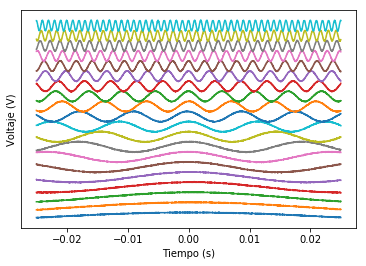

In [ ]:
[plt.plot(tiempos[k], señales[k] + .500 * k, alpha=1) for k in range(len(tiempos))]
plt.yticks([])
plt.ylabel("Voltaje (V)")
plt.xlabel("Tiempo (s)")
plt.show()

In [ ]:
#Si no queremos que se nos vayan recortando las señales

#Seteamos el autorange en prendido
osci.write("AUTORANGE:STATE OFF")

señales = []
tiempos = []

for freq in np.logspace(1, 5, 5):

    #Fijamos la escala horizontal para que haya 5 periodos
    t_total_pantalla = 5 / freq
    cant_divisiones = 10
    osci.write("HORizontal:MAIn:SCAle {:f}".format(t_total_pantalla / cant_divisiones))

    #Cambiamos la frecuencia del generador
    fungen.write('SOURCE1:FREQUENCY {:f}'.format(freq) )
    print('Comando enviado: ' + 'FREQ {:f}'.format(freq)  )

    time.sleep(10/freq)  # tiempo de espera para que el oscilo reciba ok

    #Adquirimos
    # Le pido algunos parametros de la pantalla, para poder escalear adecuadamente
    xze, xin, yze, ymu, yoff = osci.query_ascii_values('WFMPRE:XZE?;XIN?;YZE?;YMU?;YOFF?;', separator=';')

    # Con el método 'write' enviamos instrucciones QUE NO TIENEN RESPUESTA
    # Modo de transmisión: Binario
    osci.write('DAT:ENC RPB')
    osci.write('DAT:WID 1')

    # Adquiere los datos del canal 1 y los devuelve en un array de numpy
    data = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    voltaje =(data-yoff)*ymu+yze;
    tiempo = xze + np.arange(len(data)) * xin

    señales.append(voltaje)
    tiempos.append(tiempo)

#     time.sleep(.1)
    print("Señal adquirida")

Comando enviado: FREQ 10.000000
Señal adquirida
Comando enviado: FREQ 100.000000
Señal adquirida
Comando enviado: FREQ 1000.000000
Señal adquirida
Comando enviado: FREQ 10000.000000
Señal adquirida
Comando enviado: FREQ 100000.000000
Señal adquirida


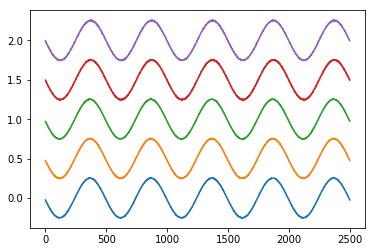

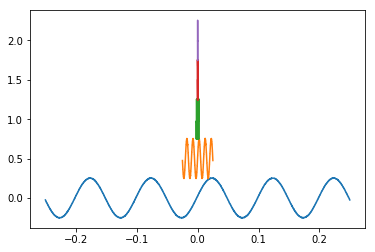

In [ ]:
[plt.plot(señales[k] + .500 * k, alpha=1) for k in range(len(tiempos))]
plt.show()

[plt.plot(tiempos[k], señales[k] + .500 * k, alpha=1) for k in range(len(tiempos))]
plt.show()